In [1]:
import pyreadr
import statsmodels
import pandas as pd
import numpy as np
from datetime import datetime as dt
from plot_keras_history import show_history, plot_history
import os 
from sklearn.linear_model import LinearRegression 
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K


from sklearn.cluster import KMeans
np.random.seed(42)

In [2]:
data_ml = pyreadr.read_r(os.path.join(os.path.expanduser('~'),'Downloads','data_ml.RData'))["data_ml"]
data_ml.date = pd.to_datetime(data_ml.date)
data_ml = data_ml.loc[(data_ml['date'] > "1999-12-31") & (data_ml['date'] < "2019-01-01")]
data_ml.sort_values(by = ['stock_id','date'], inplace = True)
data_ml['R1M_Usd_C'] = data_ml.R1M_Usd >  data_ml.groupby('date').R1M_Usd.transform('median')


features = list(data_ml.columns[2:95])
features_short = ["Div_Yld", "Eps", "Mkt_Cap_12M_Usd", "Mom_11M_Usd", 
                    "Ocf", "Pb", "Vol1Y_Usd"]
stock_ids = data_ml.stock_id.unique()                                                                                           
stock_days = data_ml.stock_id.value_counts().sort_index()                                           
stock_ids_short = stock_ids[stock_days.values == max(stock_days.values)]                            
returns_short = data_ml[data_ml['stock_id'].isin(stock_ids_short)][['date','stock_id','R1M_Usd']]
returns = returns_short.pivot_table(index='date',columns='stock_id',values='R1M_Usd')
separation_date = dt.strptime("2014-01-15","%Y-%m-%d")
training_sample = data_ml[data_ml.date < separation_date]
testing_sample = data_ml[data_ml.date  >= separation_date]


In [3]:
NN_train_features = training_sample[features].to_numpy()
NN_train_labels = training_sample['R1M_Usd'].to_numpy()
NN_test_features = testing_sample[features].to_numpy()
NN_test_labels = testing_sample['R1M_Usd'].to_numpy()

In [4]:
model = keras.Sequential([
        keras.layers.Dense(units=16, activation="relu", input_shape = (NN_train_features.shape[1],)),
        keras.layers.Dense(units=8, activation="tanh"),
        keras.layers.Dense(units=1)
])

c:\Users\SE24171\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [5]:
model.compile(
              loss='mean_squared_error',      
              optimizer=keras.optimizers.RMSprop(),         
              metrics=['mean_absolute_error']  
)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │         1,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,649 (6.44 KB)

 Trainable params: 1,649 (6.44 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0429 - mean_absolute_error: 0.1114 - val_loss: 0.0372 - val_mean_absolute_error: 0.0671
Epoch 2/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0379 - mean_absolute_error: 0.0847 - val_loss: 0.0372 - val_mean_absolute_error: 0.0674
Epoch 3/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0290 - mean_absolute_error: 0.0844 - val_loss: 0.0371 - val_mean_absolute_error: 0.0669
Epoch 4/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0232 - mean_absolute_error: 0.0835 - val_loss: 0.0396 - val_mean_absolute_error: 0.0814
Epoch 5/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0280 - mean_absolute_error: 0.0841 - val_loss: 0.0372 - val_mean_absolute_error: 0.0679
Epoch 6/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0265 - mean_absolute_error: 0.0839 - val_loss: 0.0370 - val_mean_absolute_error: 0.0667
Epoch 7/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0247 - mean_absolute_error: 0.0837 - v

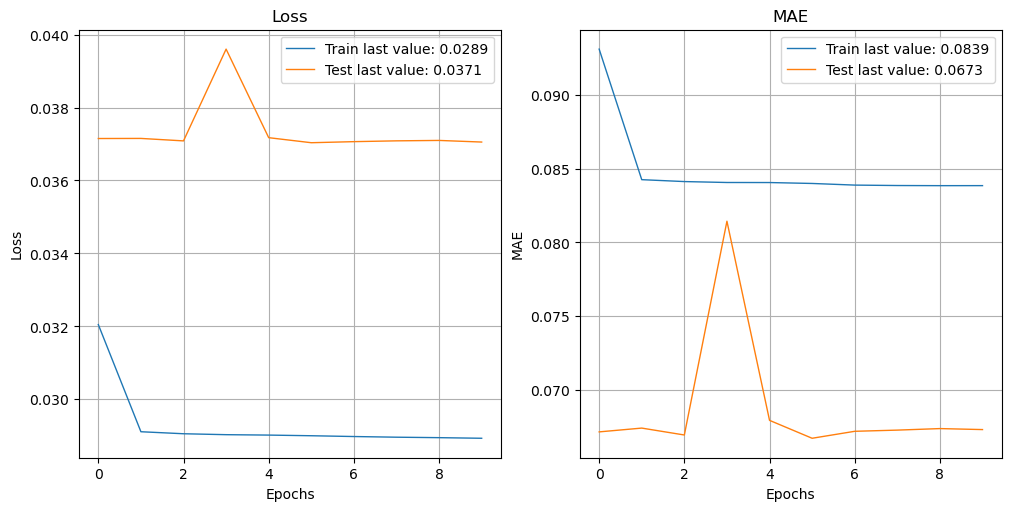

In [6]:
fit_NN = model.fit(
                  NN_train_features,                                   
                  NN_train_labels,                                     
                  epochs = 10, 
                  batch_size = 512,                              
                  validation_data = (NN_test_features, NN_test_labels)  
                  )
show_history(fit_NN)  
# plt.subplot(2,1,1)
# plt.plot(fit_NN.history['loss'])
# plt.plot(fit_NN.history['val_loss'])
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['training', 'validation'], loc='upper right')

# plt.subplot(2,1,2)
# plt.plot(fit_NN.history['MeanAbsoluteError'])
# plt.plot(fit_NN.history['val_MeanAbsoluteError'])
# plt.ylabel('mean_absolute_error')
# plt.xlabel('epoch')
# plt.legend(['training', 'validation'], loc='upper right')

In [7]:
print("Hit ratio:", ((model.predict(NN_test_features).flatten() * NN_test_labels) >0).mean())


2194/2194 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Hit ratio: 0.5161377620783957


In [8]:
NN_train_labels_C = pd.get_dummies(training_sample["R1M_Usd_C"]).to_numpy()
NN_test_labels_C = pd.get_dummies(testing_sample["R1M_Usd_C"]).to_numpy()

In [ ]:
model_C = keras.Sequential([
        keras.layers.Dense(
                units=16, activation="tanh",input_shape=(NN_train_features.shape[1],) ,               
                kernel_initializer=keras.initializers.RandomNormal(),                       
                kernel_constraint=keras.constraints.NonNeg()                               
                ),
        keras.layers.Dropout(0.25),                                                        
        keras.layers.Dense(
                        units=8, activation="elu",                                    
                        bias_initializer= keras.initializers.Constant(0.2), 
                        kernel_regularizer=keras.regularizers.l2(0.01)            
                        ),
        keras.layers.Dense(2, activation="softmax")   
        ])


c:\Users\SE24171\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model_C.compile(
              loss='binary_crossentropy',                                                  
              optimizer=keras.optimizers.Adam(learning_rate=0.005, beta_1=0.9, beta_2=0.95), 
              metrics=['categorical_accuracy'] 
              )                                                
model_C.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 16)             │         1,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,658 (6.48 KB)

 Trainable params: 1,658 (6.48 KB)

 Non-trainable params: 0 (0.00 B)

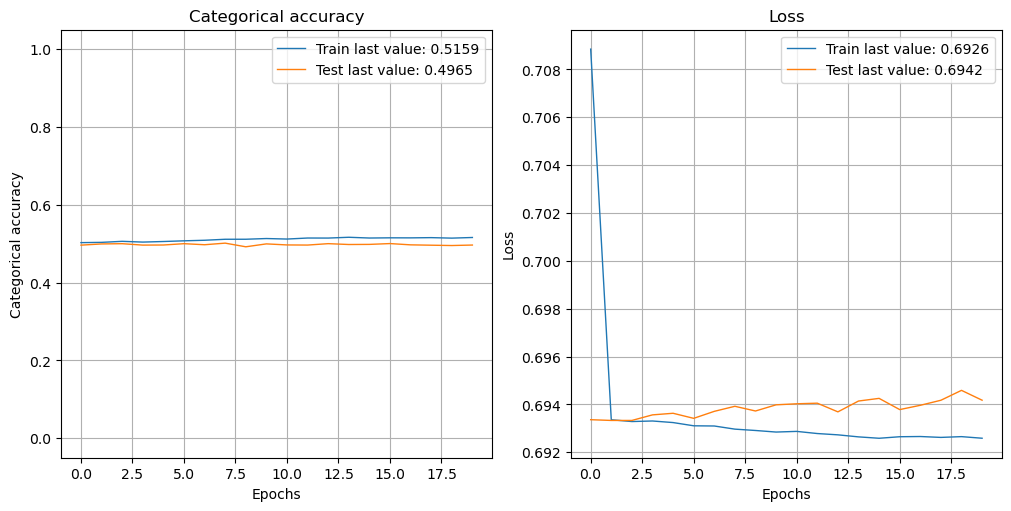

In [11]:
early_stopping = EarlyStopping(
                            monitor="val_loss", 
                            min_delta=0.001,    # Improvement threshold
                            patience=3,         # Nb epochs with no improvmt 
                            verbose=0           
                            )

fit_NN_C = model_C.fit(
                  NN_train_features, 
                  NN_train_labels_C,                          
                  epochs = 20, batch_size = 512,                                      
                  validation_data = (NN_test_features, NN_test_labels_C),             
                  verbose = 0,                                                        
                #   callbacks = [early_stopping]                                            
                      )
show_history(fit_NN_C)  


In [12]:
model_custom = keras.Sequential([
            keras.layers.Dense(16, activation="relu", input_shape=(NN_train_features.shape[1],)) , 
            keras.layers.Dense(8, activation="sigmoid"),
            keras.layers.Dense(1),
        ])

c:\Users\SE24171\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
def metric_cust(y_true, y_pred):
    return K.mean((y_pred - K.mean(y_pred))**2) - 5 * K.mean((y_true - K.mean(y_true)) * (y_pred - K.mean(y_pred)))

model_custom.compile(
    loss=metric_cust,
    optimizer=keras.optimizers.RMSprop(),
    metrics=['mean_absolute_error']
)

Epoch 1/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1.1871e-04 - mean_absolute_error: 0.4903 - val_loss: -1.2867e-04 - val_mean_absolute_error: 0.5254
Epoch 2/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: -7.8221e-04 - mean_absolute_error: 0.5281 - val_loss: 4.1600e-05 - val_mean_absolute_error: 0.5155
Epoch 3/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: -9.7090e-04 - mean_absolute_error: 0.5160 - val_loss: -3.5539e-06 - val_mean_absolute_error: 0.5161
Epoch 4/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: -0.0013 - mean_absolute_error: 0.5108 - val_loss: -5.2064e-05 - val_mean_absolute_error: 0.5282
Epoch 5/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: -0.0014 - mean_absolute_error: 0.5144 - val_loss: 6.8431e-05 - val_mean_absolute_error: 0.4957
Epoch 6/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: -0.0012 - mean_absolute_error: 0.4980 - val_loss: -3.8223e-05 - val_mean_absolute_error: 0.4950
Epoch 7/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - l

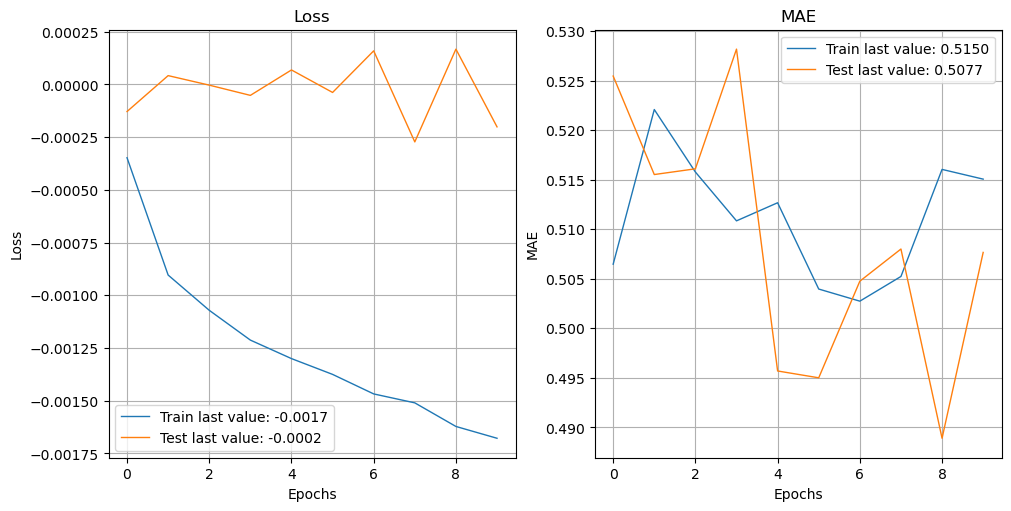

In [14]:
fit_NN_cust = model_custom.fit(
    NN_train_features, NN_train_labels,
    epochs=10, 
    batch_size=512,
    validation_data=(NN_test_features, NN_test_labels)
)
show_history(fit_NN_cust)  


In [15]:
print("Hit ratio:", ((model_custom.predict(NN_test_features).flatten() * NN_test_labels) >0).mean())


2194/2194 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Hit ratio: 0.5460346399270738


In [16]:
data_rnn = data_ml[data_ml['stock_id'].isin(stock_ids_short)]
training_sample_rnn  = data_rnn[data_rnn.date < separation_date]
testing_sample_rnn  = data_rnn[data_rnn.date > separation_date]
nb_stocks = len(stock_ids_short)
nb_feats = len(features)
nb_dates_train = len(training_sample_rnn) // nb_stocks
nb_dates_test = len(testing_sample_rnn) // nb_stocks

train_features_rnn = training_sample_rnn[features].to_numpy().reshape((nb_stocks, nb_dates_train, nb_feats)) 
test_features_rnn = testing_sample_rnn[features].to_numpy().reshape((nb_stocks, nb_dates_test, nb_feats)) 
train_labels_rnn  = training_sample_rnn['R1M_Usd'].to_numpy().reshape((nb_stocks, nb_dates_train, 1)) 
test_labels_rnn  = testing_sample_rnn['R1M_Usd'].to_numpy().reshape((nb_stocks, nb_dates_test, 1)) 

In [17]:
model_RNN = keras.Sequential([
    keras.layers.GRU(
                    units=16, 
                    input_shape=(nb_dates_train, nb_feats), 
                    activation='tanh', 
                    return_sequences=True, 
                    ),
    keras.layers.Dense(units=1)
])
model_RNN.compile(
    loss='mean_squared_error',
    optimizer=keras.optimizers.RMSprop(),
    metrics=['mean_absolute_error']
)


c:\Users\SE24171\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


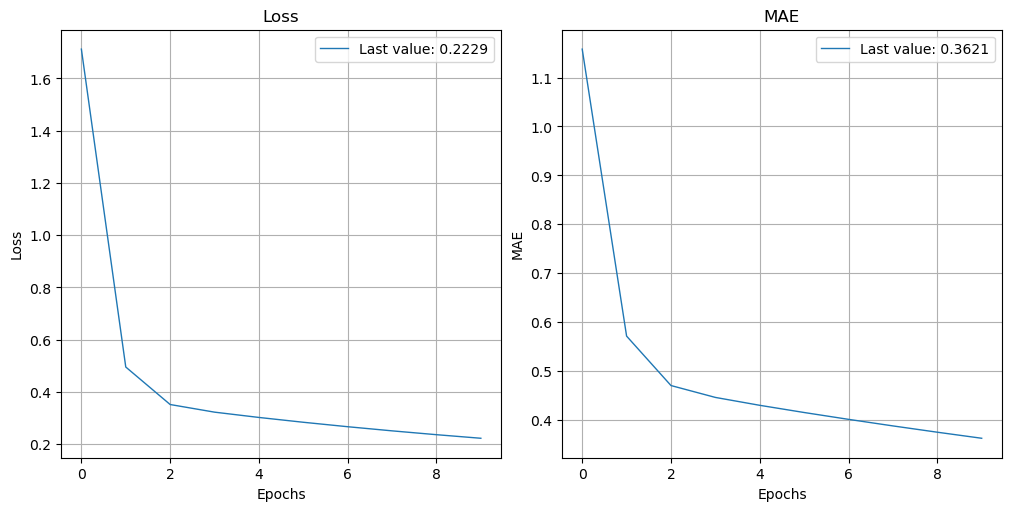

In [18]:
fit_RNN = model_RNN.fit(
    train_features_rnn, 
    train_labels_rnn,   
    epochs=10,          
    batch_size=nb_stocks,  
    verbose=0            
)
show_history(fit_RNN)

In [19]:
new_model = keras.Sequential([
    keras.layers.GRU(
                    units=16, 
                    input_shape=(nb_dates_train, nb_feats), 
                    activation='tanh', 
                    return_sequences=True, 
                    ),
    keras.layers.Dense(units=1)
])

new_model.set_weights(model_RNN.get_weights())

c:\Users\SE24171\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [20]:
pred_rnn = new_model.predict(test_features_rnn, batch_size=nb_stocks)
print("Hit ratio:",  ((pred_rnn.flatten() * test_labels_rnn.flatten()) > 0).mean())


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
Hit ratio: 0.50010508617066


In [21]:
data_short = data_ml.loc[data_ml['stock_id'].isin(stock_ids_short)][['stock_id', 'date','R1M_Usd'] + features_short]
dates = data_short['date'].unique()
N = len(stock_ids_short)
Tt = len(dates)
K = len(features_short)

factor_data = data_short.pivot(index="date", columns="stock_id", values="R1M_Usd").to_numpy()
beta_data = data_short.drop(columns=["stock_id", "date", "R1M_Usd"]).to_numpy()
beta_data = beta_data.reshape(N, Tt, K).transpose(1, 0, 2)
beta_data.shape


(228, 793, 7)

In [22]:
main_input = keras.layers.Input(shape=(N,), name="main_input")
factor_network = keras.layers.Dense(8, activation="relu", name="layer_1_r")(main_input)
factor_network = keras.layers.Dense(4, activation="tanh", name="layer_2_r")(factor_network)

aux_input = keras.layers.Input(shape=(N, K), name="aux_input")
beta_network = keras.layers.Dense(8, activation="relu", name="layer_1_l")(aux_input)
beta_network = keras.layers.Dense(4, activation="tanh", name="layer_2_l")(beta_network)
beta_network = keras.layers.Permute((2, 1), name="layer_3_l")(beta_network)

main_output = keras.layers.Dot(axes=1, name="main_output")([beta_network, factor_network])
model_ae = keras.models.Model(inputs=[main_input, aux_input], outputs=main_output)
model_ae.compile(optimizer="rmsprop", loss="mean_squared_error")
model_ae.summary()
# model_ae.fit(
#     x={"main_input": factor_data, "aux_input": beta_data},
#     y={"main_output": factor_data},
#     epochs=20,
#     batch_size=49
# )

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ aux_input           │ (None, 793, 7)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_1_l (Dense)   │ (None, 793, 8)    │         64 │ aux_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ main_input          │ (None, 793)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_2_l (Dense)   │ (None, 793, 4)    │         36 │ layer_1_l[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_1_r (Dense)   │ (None, 8)         │      6,352 │ main_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_3_l (Permute) │ (None, 4, 793)    │          0 │ layer_2_l[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_2_r (Dense)   │ (None, 4)         │         36 │ layer_1_r[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ main_output (Dot)   │ (None, 793)       │          0 │ layer_3_l[0][0],  │
│                     │                   │            │ layer_2_r[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,488 (25.34 KB)

 Trainable params: 6,488 (25.34 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
model_ua = keras.Sequential([
    keras.layers.Dense(units = 16, activation = 'sigmoid', input_shape = (1,)),
    keras.layers.Dense(units = 1)
]) 
model_ua.compile(                      
    loss = 'mean_squared_error',                  
    optimizer = keras.optimizers.RMSprop(),
    metrics=['mean_absolute_error']           
)

X = np.arange(0,6,step=0.001)
y = np.sin(X)
fit_ua = model_ua.fit(
                X,y,
                epochs = 30, batch_size = 64                                               
)

Epoch 1/30


c:\Users\SE24171\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3278 - mean_absolute_error: 0.5102  
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2188 - mean_absolute_error: 0.4144
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1900 - mean_absolute_error: 0.3835
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1782 - mean_absolute_error: 0.3672
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step - loss: 0.1761 - mean_absolute_error: 0.3650
Epoch 6/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1733 - mean_absolute_error: 0.3610
Epoch 7/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1733 - mean_absolute_error: 0.3635
Epoch 8/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1703 - mean_absolute_error: 0.3592
Epoch 9/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1686 - mean_absolute_error: 0.3577
Epoch 10/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1702 - mean_absolute_error: 0.3612
Epoch 11/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - los

In [24]:
model_ua2 = keras.Sequential([
    keras.layers.Dense(units = 128, activation = 'sigmoid', input_shape = (1,)),
    keras.layers.Dense(units = 1)
]) 
model_ua2.compile(                      
    loss = 'mean_squared_error',                  
    optimizer = keras.optimizers.RMSprop(),
    metrics=['mean_absolute_error']           
)
X = np.arange(0,6,step=0.0002)
y = np.sin(X)
fit_ua = model_ua2.fit(
                X,y,
                epochs = 60, batch_size = 64                                              
)

Epoch 1/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.2573 - mean_absolute_error: 0.4372
Epoch 2/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1755 - mean_absolute_error: 0.3636
Epoch 3/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1755 - mean_absolute_error: 0.3642
Epoch 4/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1741 - mean_absolute_error: 0.3634
Epoch 5/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1735 - mean_absolute_error: 0.3623
Epoch 6/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1743 - mean_absolute_error: 0.3626
Epoch 7/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1739 - mean_absolute_error: 0.3628
Epoch 8/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1728 - mean_absolute_error: 0.3616
Epoch 9/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1751 - mean_absolute_error: 0.3643
Epoch 10/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1745 - mean_absolute_error: 0.3628
Epoch 11/60
469/469 ━━━━━━━━━

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


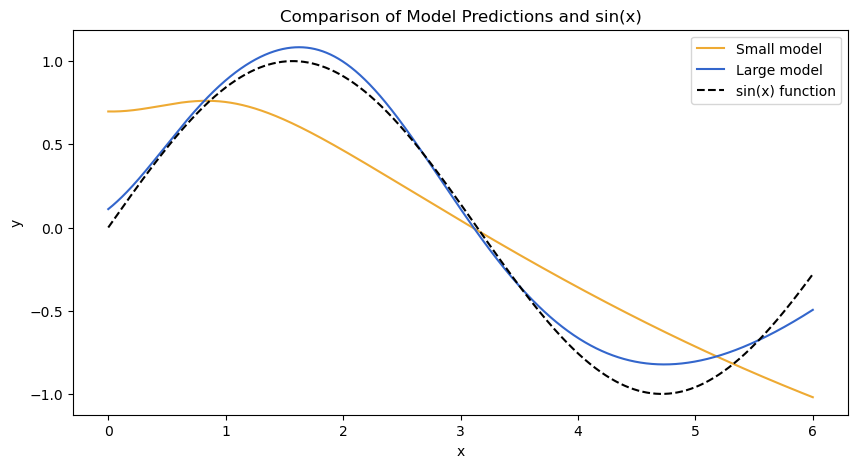

In [25]:
x = np.arange(0, 6, 0.001)
y_small_model = model_ua.predict(x.reshape(-1, 1))  
y_large_model = model_ua2.predict(x.reshape(-1, 1))  
y_true = np.sin(x) 

plt.figure(figsize=(10, 5))
plt.plot(x, y_small_model, label="Small model", color="#EEAA33")
plt.plot(x, y_large_model, label="Large model", color="#3366CC")
plt.plot(x, y_true, label="sin(x) function", color="#000000", linestyle="dashed")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Comparison of Model Predictions and sin(x)")
plt.show()